Loading data: outputs/final_results/rooftop_solar_potential_optimized.geojson ...
Successfully reclassified 7 large institutional buildings (outliers) to 'Hospital'.

Statistical Summary
Type            Count      Total Potential (MWh/yr) 
--------------------------------------------------
Residential     3767       58,728.67
Commercial      604        39,723.48
Industrial      44         5,205.97
Other           193        29,570.51


C:\Users\Asus\AppData\Local\Temp\ipykernel_41176\4234702895.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=total_potential.index, y=total_potential.values, ax=axes[0], palette=palette)
C:\Users\Asus\AppData\Local\Temp\ipykernel_41176\4234702895.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=gdf, x='zoning_type_clean', y='potential_kwh', order=existing_types, ax=axes[1], palette=palette, showfliers=False)


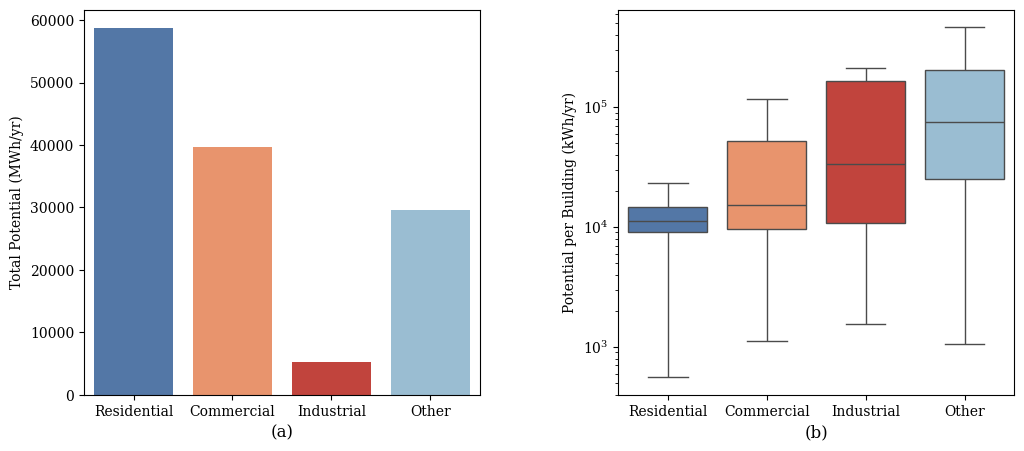


Figure saved to: outputs/Fig/Fig_Solar_Potential_By_Zoning.pdf


In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# Section 1: Configuration
INPUT_FILE = 'outputs/final_results/rooftop_solar_potential_optimized.geojson'
OUTPUT_IMG = 'outputs/Fig/Fig_Solar_Potential_By_Zoning.pdf'

# Check input file availability
if not os.path.exists(INPUT_FILE):
    print(f"Error: File not found: {INPUT_FILE}")
else:
    print(f"Loading data: {INPUT_FILE} ...")
    gdf = gpd.read_file(INPUT_FILE)

    # Validate data structure
    if 'zoning_type' not in gdf.columns:
        print("Error: Column 'zoning_type' is missing. Please ensure the economic and zoning analysis step has been completed.")
    else:
        # Section 2: Data Reclassification & Sanitization
        
        # Step 1: Initialize a clean zoning column
        gdf['zoning_type_clean'] = gdf['zoning_type']
    
        # Step 2: Define area threshold for anomaly detection
        # Large institutional buildings often get misclassified as Residential in raw zoning data.
        AREA_THRESHOLD_FOR_HOSPITAL = 3000 
    
        # Identify oversized buildings incorrectly labeled as 'Residential'
        is_residential = gdf['zoning_type'].astype(str).str.contains('Residential', case=False, na=False)
        is_oversized = gdf['area_m2'] > AREA_THRESHOLD_FOR_HOSPITAL

        outlier_mask = is_residential & is_oversized

        # Step 3: Reclassify outliers as 'Hospital' (Institutional)
        if outlier_mask.any():
            gdf.loc[outlier_mask, 'zoning_type_clean'] = 'Hospital'
            print(f"Successfully reclassified {outlier_mask.sum()} large institutional buildings (outliers) to 'Hospital'.")

        # Section 3: Statistical Analysis
        
        # Define target categories and order
        target_order = ['Residential', 'Commercial', 'Industrial', 'Other']
    
        # Standardize categories: map unrecognized types to 'Other'
        valid_types = [t for t in target_order if t != 'Other']
        gdf['zoning_type_clean'] = gdf['zoning_type_clean'].apply(lambda x: x if x in valid_types else 'Other')

        # Filter for existing types only to maintain clean plots
        existing_types = [t for t in target_order if t in gdf['zoning_type_clean'].unique()]
    
        # Calculate Aggregates
        # Total Potential (converted to MWh)
        total_potential = gdf.groupby('zoning_type_clean')['potential_kwh'].sum() / 1000 
        total_potential = total_potential.reindex(existing_types)
    
        # Building Counts
        counts = gdf['zoning_type_clean'].value_counts().reindex(existing_types)

        print("\nStatistical Summary")
        print(f"{'Type':<15} {'Count':<10} {'Total Potential (MWh/yr)':<25}")
        print("-" * 50) # kept simple line for table readability
        for ztype in existing_types:
            print(f"{ztype:<15} {counts[ztype]:<10} {total_potential[ztype]:,.2f}")

        # Section 4: Visualization
        
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['font.size'] = 10
        
        # Initialize Figure (12x5 inches)
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Define Color Palette (Academic/Journal Standard)
        palette = {
            'Residential': '#4575b4',  # Steel Blue
            'Commercial':  '#fc8d59',  # Soft Orange
            'Industrial':  '#d73027',  # Brick Red
            'Other':       '#91bfdb'   # Light Blue/Grey
        }
        
        # Left Panel: Total Potential (Bar Chart)
        sns.barplot(x=total_potential.index, y=total_potential.values, ax=axes[0], palette=palette)
            
        axes[0].set_ylabel('Total Potential (MWh/yr)', fontsize=10)
        axes[0].set_xlabel('(a)', fontsize=12)

        # Right Panel: Distribution per Building (Box Plot)
        # Note: Using 'zoning_type_clean' to maintain consistency with the left panel
        sns.boxplot(data=gdf, x='zoning_type_clean', y='potential_kwh', order=existing_types, ax=axes[1], palette=palette, showfliers=False)
        
        # Apply Logarithmic Scale for Y-axis to handle wide distribution ranges
        axes[1].set_yscale('log')
        
        axes[1].set_ylabel('Potential per Building (kWh/yr)', fontsize=10)
        axes[1].set_xlabel('(b)', fontsize=12)
        
        # Add mean markers (Optional, currently commented out)
        # means = gdf.groupby('zoning_type_clean')['potential_kwh'].mean().reindex(existing_types)
        # axes[1].scatter(range(len(means)), means.values, color='yellow', s=100, zorder=10, label='Mean', edgecolors='black')

        # Adjust subplot spacing
        # wspace=0.35 ensures labels do not overlap
        plt.subplots_adjust(wspace=0.35) 
        
        # Save and Display
        plt.savefig(OUTPUT_IMG, dpi=300, format='pdf')
        plt.show()
        
        print(f"\nFigure saved to: {OUTPUT_IMG}")